In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
end_date   = dt.datetime.today()
start_date = end_date - dt.timedelta(days=8000)

df_original = yf.download('^NSEI', start=start_date, end = end_date, interval='1d')
df = df_original.copy()

[*********************100%***********************]  1 of 1 completed


<AxesSubplot:xlabel='Date'>

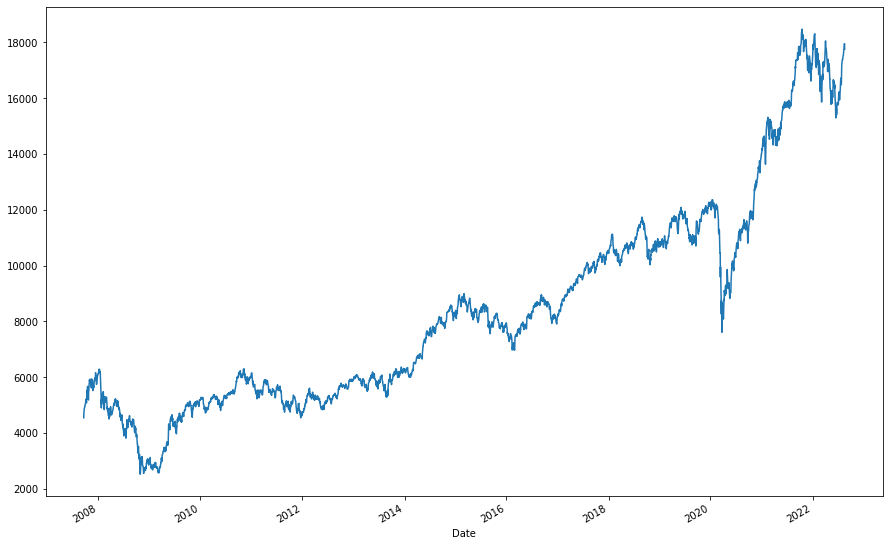

In [21]:
init_notebook_mode(connected = True)
cf.go_offline()
#ploting the daily close price
#df['Adj Close'].iplot()
df['Adj Close'].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

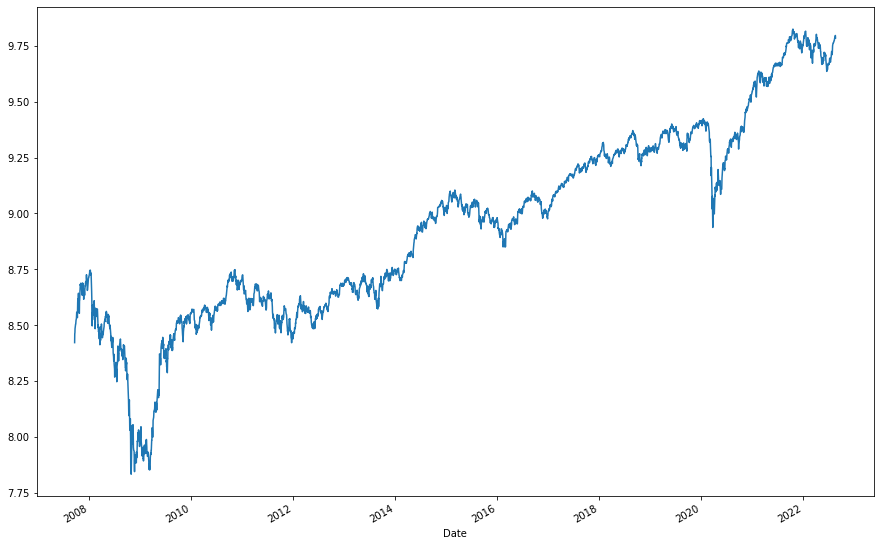

In [22]:
df['log_close'] = np.log(df['Adj Close'])

# to visuvalise the severity of bearish fall
#df['log_close'].iplot()
df['log_close'].plot(figsize=(15,10))

In [5]:
df['log_return'] = (df['log_close'] - df['log_close'].shift())*100
df.dropna(inplace=True)

<AxesSubplot:xlabel='Date'>

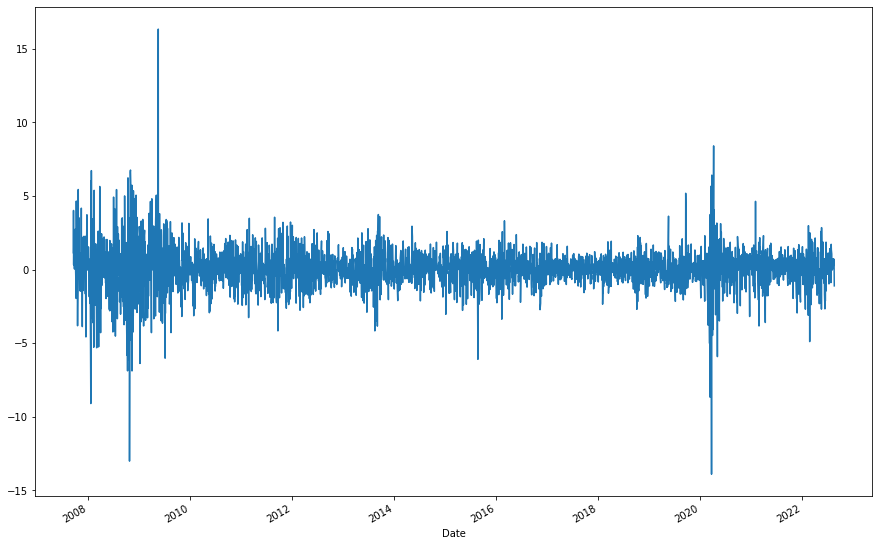

In [23]:
#visualising the daily log return data
#df['log_return'].iplot()
df['log_return'].plot(figsize=(15,10))

In [7]:
from statsmodels.tsa.stattools import adfuller

stationarity_test = adfuller(df['log_return'])
p_val_stationary = stationarity_test[1]
print(f'p-value of the stationary test is {p_val_stationary}\n')

if p_val_stationary<0.05:
    print('Daily log return time series is stationary with 95% confidence')
else:
    print('Time series is not stationary with 95% confidence')

p-value of the stationary test is 2.3235737719437367e-29

Daily log return time series is stationary with 95% confidence


<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Nifty Returns')

[Text(0.5, 0, ''), Text(0, 0.5, 'Percentage Return')]

<AxesSubplot:xlabel='Date'>

[Text(0.5, 0, ''), Text(0, 0.5, 'Trend')]

<AxesSubplot:xlabel='Date'>

[Text(0.5, 0, ''), Text(0, 0.5, 'Seasonal')]

<AxesSubplot:xlabel='Date'>

[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Residual')]

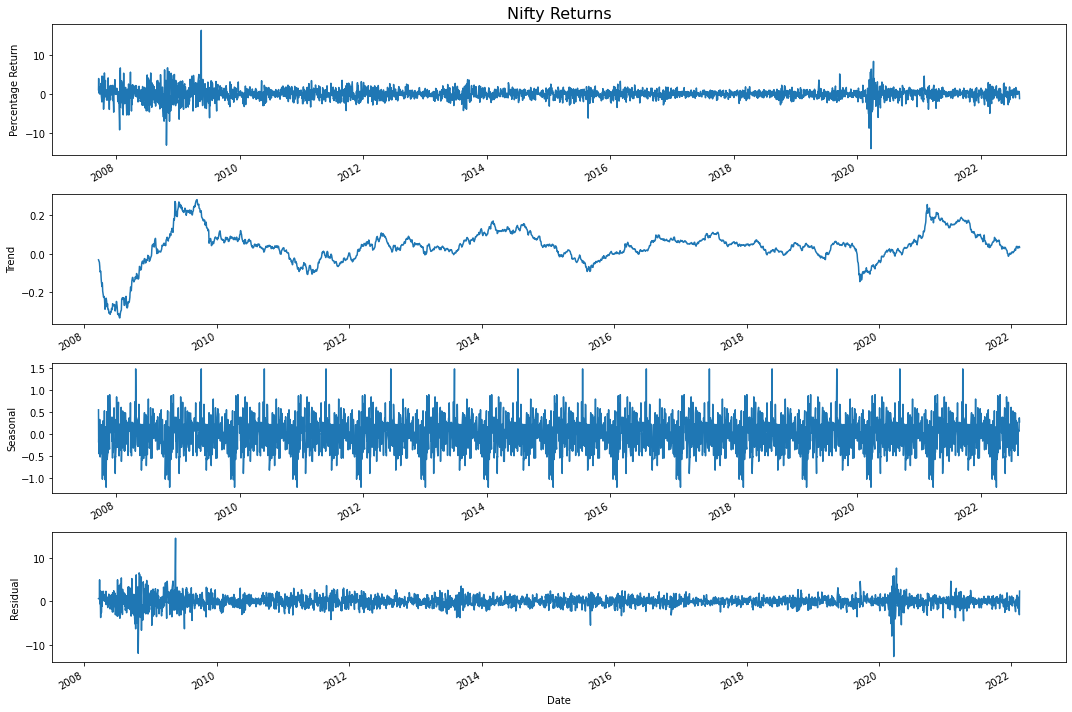

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_series = seasonal_decompose(df['log_return'],period=252)

fig,ax = plt.subplots(4,1, figsize=(15,10))

decompose_series.observed.plot(ax=ax[0])
ax[0].set_title("Nifty Returns", fontsize=16)
ax[0].set(xlabel='',ylabel='Percentage Return')

decompose_series.trend.plot(ax=ax[1])
ax[1].set(xlabel='',ylabel='Trend')

decompose_series.seasonal.plot(ax=ax[2])
ax[2].set(xlabel='',ylabel='Seasonal')

decompose_series.resid.plot(ax=ax[3])
ax[3].set(xlabel='Date',ylabel='Residual')

plt.tight_layout()
plt.show()

In [9]:
# Spliting data into 2 part: Train data and Test Data
split_size = int(len(df)*0.8)
train_df, test_df = df.iloc[:split_size], df.iloc[split_size:]

In [10]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# import warning to supress the warning due to datetime index in DataFrame
import warnings
warnings.simplefilter('ignore')

#setting freq to daily 
#if data is not daily data uncomment below lines

train_df = train_df.asfreq('d').dropna()
train_df.dropna(inplace=True)


In [11]:
arima_model = smt.SARIMAX(train_df['Adj Close'],order=(5,1,5))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2924
Model:               SARIMAX(5, 1, 5)   Log Likelihood              -16836.892
Date:                Mon, 22 Aug 2022   AIC                          33695.783
Time:                        00:38:08   BIC                          33761.567
Sample:                             0   HQIC                         33719.477
                               - 2924                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5563      0.376     -1.479      0.139      -1.293       0.181
ar.L2         -0.0394      0.045     -0.869      0.385      -0.128       0.049
ar.L3         -0.0781      0.048     -1.622      0.105      -0.173       0.016
ar.L4         -0.9086      0.042    -21.593      0.000      -0.991      -0.826
ar.L5         -0.4823      0.330     -1.463      0.143      -1.128       0.164
ma.L1          0.6209      0.371      1.673      0.094      -0.106       1.348
ma.L2          0.0832      0.051      1.646      0.100      -0.016       0.182
ma.L3          0.0727      0.053      1.370      0.171      -0.031       0.177
ma.L4          0.9102      0.045     20.424      0.000       0.823       0.998
ma.L5          0.5149      0.325      1.583      0.113      -0.123       1.152
sigma2      5920.6799     99.900     59.266      0.000    5724.879    6116.480
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):              1626.54
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
import pmdarima as pm

optimum_arima = pm.auto_arima(train_df['Adj Close'],
                             information_criterion='aic',
                             stepwise=False,
                             suppress_warnings=False,
                             seasonal=False)
print(optimum_arima)

 ARIMA(2,1,2)(0,0,0)[0] intercept


In [13]:
# ARIMA model on daily Close price
optimum_arima_model = smt.SARIMAX(train_df['Adj Close'],order=(2,1,2))
optimum_arima_result = optimum_arima_model.fit()
optimum_arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 2924
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -16844.219
Date:                Mon, 22 Aug 2022   AIC                          33698.438
Time:                        00:38:37   BIC                          33728.339
Sample:                             0   HQIC                         33709.207
                               - 2924                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2010      0.118     10.190      0.000       0.970       1.432
ar.L2         -0.5783      0.115     -5.015      0.000      -0.804      -0.352
ma.L1         -1.1332      0.123     -9.176      0.000      -1.375      -0.891
ma.L2          0.5056      0.122      4.132      0.000       0.266       0.745
sigma2      5973.9438     94.410     63.276      0.000    5788.903    6158.985
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1726.67
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# ARMA model on daily log return
optimum_arma_model = smt.SARIMAX(train_df['log_return'],order=(2,0,2))
optimum_arma_result = optimum_arma_model.fit()
optimum_arma_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             log_return   No. Observations:                 2924
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -5094.388
Date:                Mon, 22 Aug 2022   AIC                          10198.776
Time:                        00:38:38   BIC                          10228.679
Sample:                             0   HQIC                         10209.546
                               - 2924                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8666      2.338      0.371      0.711      -3.717       5.450
ar.L2          0.0991      0.302      0.328      0.743      -0.493       0.692
ma.L1         -0.7885      2.339     -0.337      0.736      -5.373       3.796
ma.L2         -0.1749      0.473     -0.369      0.712      -1.103       0.753
sigma2         1.9091      0.020     97.128      0.000       1.871       1.948
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             18549.26
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

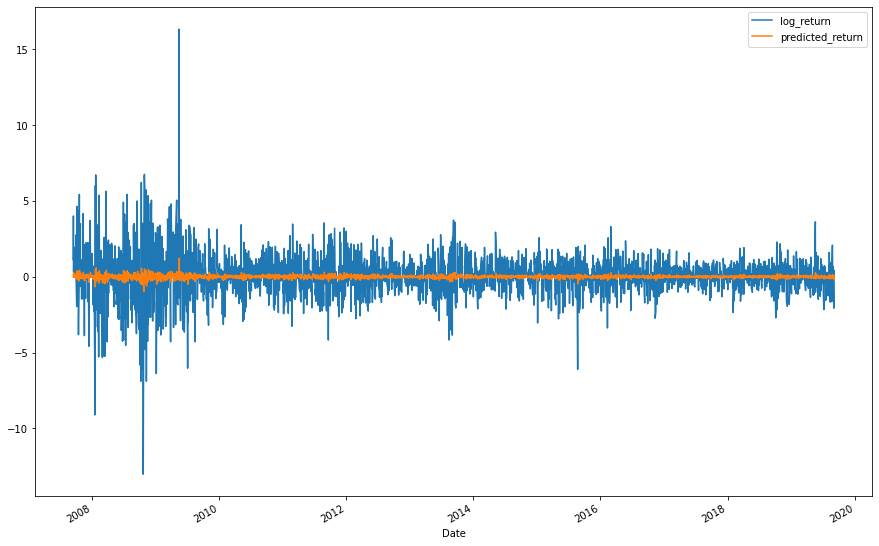

In [18]:
# prediction using optimum ARIMA model

train_df['predicted_return'] = optimum_arma_result.predict(start = train_df.index[0], end = train_df.index[-1])
#train_df[['log_return','predicted_return']].iplot()
train_df[['log_return','predicted_return']].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

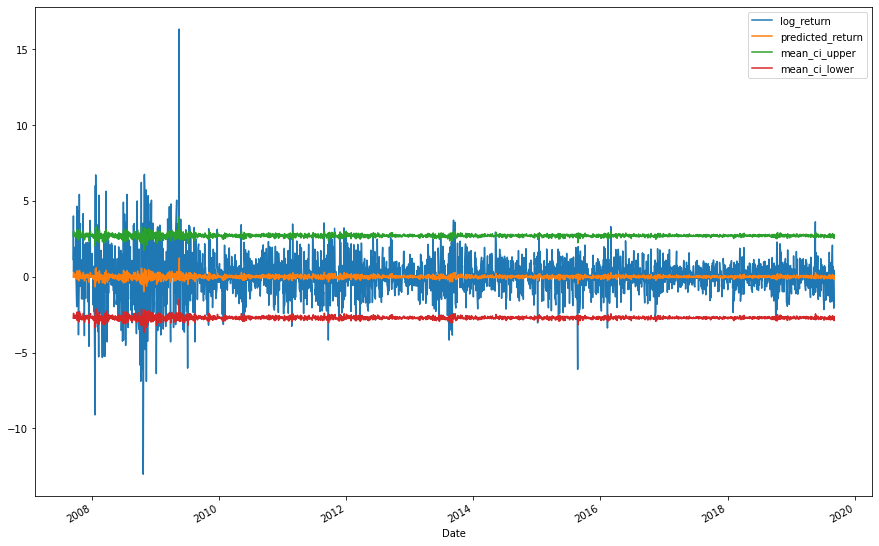

In [20]:
# prediction with confidence interval of 95% using optimum ARIMA model

predict_data = optimum_arma_result.get_prediction()
pred_df = predict_data.summary_frame()

train_df_pred = pd.concat([train_df,pred_df], axis=1)
# plotting with 95% confidence interval
#train_df_pred[['log_return', 'predicted_return', 'mean_ci_upper', 'mean_ci_lower']].iplot()
train_df_pred[['log_return', 'predicted_return', 'mean_ci_upper', 'mean_ci_lower']].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

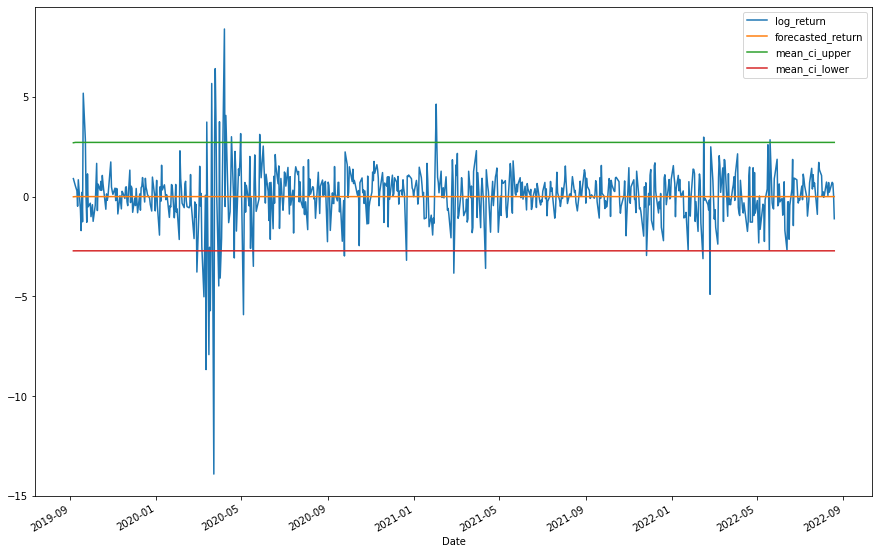

In [19]:
# forcasting using ARIMA model for test data

forecast_data = optimum_arma_result.get_forecast(steps = len(test_df))
forecast_df = forecast_data.summary_frame()
forecast_df.rename(columns = {'mean':'forecasted_return'}, inplace = True)
forecast_df.set_index(test_df.index, inplace=True)
test_df_forecasted = pd.concat([test_df,forecast_df],axis=1)
# plotting with 95% confidence interval
#test_df_forecasted[['log_return', 'forecasted_return', 'mean_ci_upper', 'mean_ci_lower']].iplot()
test_df_forecasted[['log_return', 'forecasted_return', 'mean_ci_upper', 'mean_ci_lower']].plot(figsize=(15,10))
